In [1]:
# dataframes 
import numpy as np
# import pandas as pd
import polars as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import sys
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funcion de xgboost que clasifica
from xgboost import XGBClassifier

# graficar el arbol de desiciones del modelo, rcparams es para que se vea HD
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# medir que tan bueno es el modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# encontrar mejor modelo (validacion)
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

# ver la prueba de ks
from scipy.stats import kstest

# funciones creadas
from lectura import *
from formulas import *
from cortes import *
from graficar import *
from machine_learning import *
from metricas import *

# para recargar los modulos mientras los voy debugeando
%load_ext autoreload
%autoreload 2

# tensorflow
import tensorflow as tf

2023-11-26 11:06:14.065386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 11:06:16.515223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('parametros_ml.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [3]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

 12%|█▎        | 1/8 [00:00<00:03,  2.12it/s]

samples/VBF/frvz_vbf_500757


 25%|██▌       | 2/8 [00:01<00:03,  1.93it/s]

samples/VBF/frvz_vbf_500758


 38%|███▊      | 3/8 [00:01<00:02,  1.92it/s]

samples/VBF/frvz_vbf_500759


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

samples/VBF/frvz_vbf_500760


 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

samples/VBF/frvz_vbf_500761


 75%|███████▌  | 6/8 [00:02<00:00,  2.06it/s]

samples/VBF/frvz_vbf_500762


 88%|████████▊ | 7/8 [00:03<00:00,  2.14it/s]

samples/VBF/frvz_vbf_500763


100%|██████████| 8/8 [00:03<00:00,  2.09it/s]


samples/VBF/frvz_vbf_500764


100%|██████████| 9/9 [00:15<00:00,  1.68s/it]


njet30          mjj      detajj  \
origin df_name                                                        
VBF    samples/VBF/frvz_vbf_500757       2  1316.194214    5.130603   
       samples/VBF/frvz_vbf_500757       7  2287.880371    7.156201   
       samples/VBF/frvz_vbf_500757       2  1568.506470    6.255918   
       samples/VBF/frvz_vbf_500757       4   471.740875    1.960242   
       samples/VBF/frvz_vbf_500757       8  1150.059692    4.557185   
...                                    ...          ...         ...   
ggF    samples/ggF/frvz_ggf_508893       1    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       3   240.689178    1.942230   
       samples/ggF/frvz_ggf_508893       2   143.422470    2.548514   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   

                                        dphijj         MET  scale1fb  \
origin df_name                                                         
VBF    samples/VBF/frvz_vbf_500757    1.032967  177.043106  0.000486   
       samples/VBF/frvz_vbf_500757   -2.580441  101.195091  0.000502   
       samples/VBF/frvz_vbf_500757   -1.375577  130.909744  0.000429   
       samples/VBF/frvz_vbf_500757    2.980181  491.291687  0.000531   
       samples/VBF/frvz_vbf_500757    2.197970  115.439743  0.000014   
...                                        ...         ...       ...   
ggF    samples/ggF/frvz_ggf_508893 -999.000000   40.554482  0.028479   
       samples/ggF/frvz_ggf_508893    0.768057   76.802452  0.029882   
       samples/ggF/frvz_ggf_508893    2.000947   26.644657  0.029517   
       samples/ggF/frvz_ggf_508893 -999.000000   10.709071  0.029929   
       samples/ggF/frvz_ggf_508893 -999.000000   10.808948  0.030318   

                                      intLumi        jet1_pt    jet1_eta  \
origin df_name                                                             
VBF    samples/VBF/frvz_vbf_500757  44.299999  104969.406250   -3.187121   
       samples/VBF/frvz_vbf_500757  44.299999   72039.820312    3.637084   
       samples/VBF/frvz_vbf_500757  44.299999  120273.304688   -2.382490   
       samples/VBF/frvz_vbf_500757  44.299999  178915.984375    1.259632   
       samples/VBF/frvz_vbf_500757  44.299999  189834.156250   -2.913896   
...                                       ...            ...         ...   
ggF    samples/ggF/frvz_ggf_508893  58.450001   33552.746094    0.995871   
       samples/ggF/frvz_ggf_508893  58.450001  125251.289062   -2.288580   
       samples/ggF/frvz_ggf_508893  58.450001   40318.128906   -3.305732   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   

                                      jet1_phi        jet1_e        jet2_pt  \
origin df_name                                                                
VBF    samples/VBF/frvz_vbf_500757   -0.087903  1.273288e+06   98169.875000   
       samples/VBF/frvz_vbf_500757    0.712928  1.369027e+06   56599.265625   
       samples/VBF/frvz_vbf_500757   -2.404870  6.569827e+05   39280.699219   
       samples/VBF/frvz_vbf_500757   -2.167910  3.411552e+05  133583.312500   
       samples/VBF/frvz_vbf_500757   -1.059290  1.754382e+06   72083.078125   
...                                        ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893   -2.499207  5.242589e+04    -999.000000   
       samples/ggF/frvz_ggf_508893    1.335905  6.239932e+05   79405.820312   
       samples/ggF/frvz_ggf_508893    0.382778  5.504859e+05   36411.175781   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   

                                      jet2_eta    jet2_phi        jet2_e  
origin df_name                                                            
VBF    s

In [4]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_ml = df_all_cut
df_ml = df_ml.droplevel('df_name')
df_ml = df_ml.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_ml = df_ml.reset_index(level='origin')
df_ml = pd.get_dummies(df_ml, columns=['origin'], dtype=int)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml.drop(['origin_VBF', 'origin_ggF'], axis=1) 
df_y = df_ml[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml

Numero eventos antes: 4628576
Corte: njet30 entre [1, inf]
Numero eventos despues: 2013265 



,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
3,471.740875,1.960242,2.980181,491.291687,178915.984375,1.259632,-2.167910,3.411552e+05,133583.312500,3.219874,1.135094,1.674184e+06,1,0
4,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,3.074377,36.471001,45681.097656,3.302509,-0.662832,6.216837e+05,35162.062500,2.523157,2.545976,2.206442e+05,0,1
2012572,69.304848,0.293507,-2.302855,5.845552,40501.546875,1.277558,-3.141293,7.845353e+04,33459.644531,0.984051,-0.838438,5.148936e+04,0,1
2012573,506.555878,2.252506,-3.031298,27.214394,152246.031250,1.397108,1.148800,3.269545e+05,144588.734375,-0.855398,-2.103087,2.015532e+05,0,1
2012574,240.689178,1.942230,0.768057,76.802452,125251.289062,-2.288580,1.335905,6.239932e+05,79405.820312,-0.346350,0.567848,8.514269e+04,0,1


In [5]:
df_ml['origin_ggF']
df_ml2 = df_ml.drop(['jet2_eta', 'jet1_eta', 'jet2_phi', 'MET', 'origin_ggF', 'dphijj', 'jet1_phi'], axis=1)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml2.drop(['origin_VBF'], axis=1) 
df_y = df_ml2[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3, random_state=228)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5, random_state=228)
X_test, y_test = X_metrico, y_metrico 

df_ml2

,mjj,detajj,jet1_pt,jet1_e,jet2_pt,jet2_e,origin_VBF
0,1316.194214,5.130603,104969.406250,1.273288e+06,98169.875000,3.498132e+05,1
1,2287.880371,7.156201,72039.820312,1.369027e+06,56599.265625,9.561007e+05,1
2,1568.506470,6.255918,120273.304688,6.569827e+05,39280.699219,9.452691e+05,1
3,471.740875,1.960242,178915.984375,3.411552e+05,133583.312500,1.674184e+06,1
4,1150.059692,4.557185,189834.156250,1.754382e+06,72083.078125,1.938794e+05,1
...,...,...,...,...,...,...,...
2012571,86.820213,0.779352,45681.097656,6.216837e+05,35162.062500,2.206442e+05,0
2012572,69.304848,0.293507,40501.546875,7.845353e+04,33459.644531,5.148936e+04,0
2012573,506.555878,2.252506,152246.031250,3.269545e+05,144588.734375,2.015532e+05,0
2012574,240.689178,1.942230,125251.289062,6.239932e+05,79405.820312,8.514269e+04,0


# DEEP LEARNING RECURRENTE (DEPENDENCIA TEMPORAL)

In [6]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape para que coincida con el formato de entrada de una RNN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Definir el modelo de la red neuronal recurrente (RNN)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, 6)),  # 6 características en el conjunto de datos
    tf.keras.layers.LSTM(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # Capa de salida con función de activación sigmoide para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(y_train.shape)

# Entrenar el modelo
model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.1)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

2023-11-26 11:06:40.567060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-26 11:06:42.676550: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(1408803, 1)
Epoch 1/5
79246/79246 [==============================] - 159s 2ms/step - loss: 0.1685 - accuracy: 0.9412 - val_loss: 0.1637 - val_accuracy: 0.9430
Epoch 2/5
79246/79246 [==============================] - 157s 2ms/step - loss: 0.1634 - accuracy: 0.9427 - val_loss: 0.1621 - val_accuracy: 0.9434
Epoch 3/5
79246/79246 [==============================] - 158s 2ms/step - loss: 0.1624 - accuracy: 0.9429 - val_loss: 0.1618 - val_accuracy: 0.9431
Epoch 4/5
79246/79246 [==============================] - 157s 2ms/step - loss: 0.1620 - accuracy: 0.9429 - val_loss: 0.1614 - val_accuracy: 0.9432
Epoch 5/5
18868/18868 [==============================] - 26s 1ms/step - loss: 0.1618 - accuracy: 0.9429
Loss: 0.16178007423877716, Accuracy: 0.9428874850273132


In [13]:
y_pred = model.predict(X_test)
y_pred = y_pred>0.5
matriz = confusion(y_test, y_pred)
pd.DataFrame(matriz)

18868/18868 [==============================] - 23s 1ms/step


,0,1
0,126446,20809
1,13674,442844


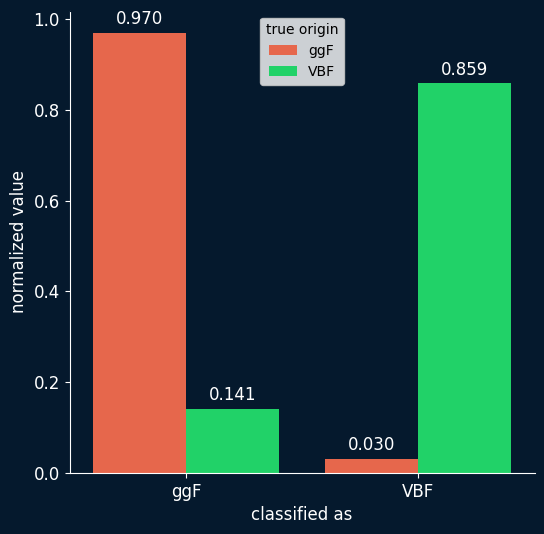

In [14]:
plot_confusion_barras(matriz)

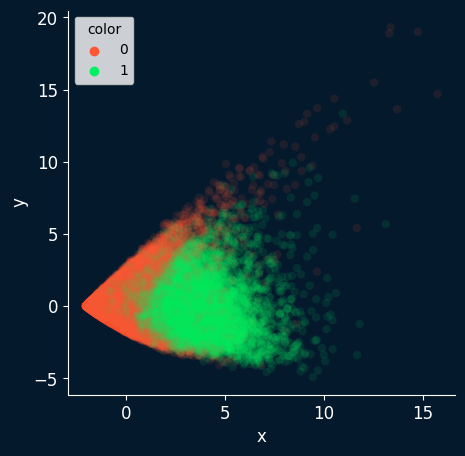

In [15]:
plot_pca_2D(model, 
            df_X.sample(100000, random_state=123), 
            df_y.sample(100000, random_state=123))

In [41]:
y_pred_all = model.predict(X_test)>0.5

18868/18868 [==============================] - 23s 1ms/step


In [44]:
y_pred = pd.DataFrame(y_pred_all).sample(100000, random_state=123)

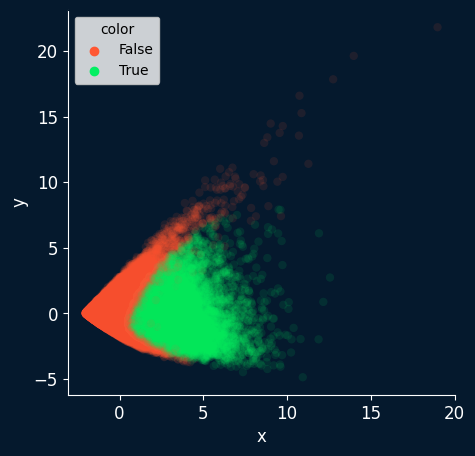

In [48]:
plot_pca_2D(model, 
            pd.DataFrame(X_test.reshape((X_test.shape[0], 6))).sample(100000, random_state=123),
            y_pred)